# Final Test Set Evaluation - School Suspension Prediction

**Purpose:** Evaluate the best model from Notebook 02 on the held-out test set

**Critical:** This notebook performs FINAL evaluation on data that was NEVER seen during training

**Structure:**
- Section 0: Setup & load best model
- Section 1: Load test set
- Section 2: Feature preparation (matching Notebook 02)
- Section 3: Model evaluation & metrics
- Section 4: Error analysis & case studies
- Section 5: Per-LGU performance analysis
- Section 6: Temporal robustness & drift analysis
- Section 7: Final report & deployment readiness

**References:**
- 01_create_master_dataset.ipynb
- 02_eda_and_core_model_all_features.ipynb

## Section 0: Setup & Configuration

In [3]:
# Cell 0.1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from pathlib import Path
import json
import joblib

# Machine learning
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve
)
from sklearn.calibration import calibration_curve

# Explainability
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("Warning: SHAP not available")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
warnings.filterwarnings('ignore')

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Paths
DATA_DIR = Path('../data')
PROCESSED_DIR = DATA_DIR / 'processed'
RESULTS_DIR = PROCESSED_DIR / 'test_results'
RESULTS_DIR.mkdir(exist_ok=True)

# LOCATION_MAPPING from Notebook 01
LOCATION_MAPPING = {
    0: 'Manila', 1: 'Quezon City', 2: 'Caloocan', 3: 'Las Piñas',
    4: 'Makati', 5: 'Malabon', 6: 'Mandaluyong', 7: 'Marikina',
    8: 'Muntinlupa', 9: 'Navotas', 10: 'Parañaque', 11: 'Pasay',
    12: 'Pasig', 13: 'Pateros', 14: 'San Juan', 15: 'Taguig',
    16: 'Valenzuela'
}

print("✅ Libraries imported successfully")
print(f"Random seed: {RANDOM_SEED}")
print(f"SHAP available: {SHAP_AVAILABLE}")
print(f"Results directory: {RESULTS_DIR}")

✅ Libraries imported successfully
Random seed: 42
SHAP available: True
Results directory: ..\data\processed\test_results


In [4]:
# Cell 0.2: Load Best Model and Metadata from Notebook 02
print("="*80)
print("LOADING BEST MODEL FROM NOTEBOOK 02")
print("="*80)

# Load metadata
with open(str(PROCESSED_DIR / 'core_model_metadata.json'), 'r') as f:
    metadata = json.load(f)

print(f"\nBest model from training: {metadata['best_model']}")
print(f"  Validation F2: {metadata['best_f2']:.4f}")
print(f"  Validation Recall: {metadata['best_recall']:.4f}")
print(f"  Validation Precision: {metadata['best_precision']:.4f}")
print(f"  Features used: {metadata['final_feature_count']}")

# Load best model
try:
    best_model = joblib.load(str(PROCESSED_DIR / 'best_core_model.pkl'))
    print(f"\n✅ Model loaded successfully: {type(best_model).__name__}")
except FileNotFoundError:
    print("\n⚠️  WARNING: best_core_model.pkl not found!")
    print("Please run Notebook 02 first to train and save the best model.")
    raise

# Store expected features
expected_features = metadata['selected_features']
print(f"\nExpected features: {len(expected_features)}")
print(f"  First 10: {expected_features[:10]}")

LOADING BEST MODEL FROM NOTEBOOK 02

Best model from training: EasyEnsemble
  Validation F2: 0.5525
  Validation Recall: 0.6020
  Validation Precision: 0.4158
  Features used: 33

✅ Model loaded successfully: EasyEnsembleClassifier

Expected features: 33
  First 10: ['year', 'month', 'day', 'day_of_week', 'is_rainy_season', 'month_from_sy_start', 'is_holiday', 'is_school_day', 'lgu_id', 'mean_flood_risk_score']

✅ Model loaded successfully: EasyEnsembleClassifier

Expected features: 33
  First 10: ['year', 'month', 'day', 'day_of_week', 'is_rainy_season', 'month_from_sy_start', 'is_holiday', 'is_school_day', 'lgu_id', 'mean_flood_risk_score']


In [5]:
# Cell 0.3: Define Metric Functions (same as Notebook 02)
def compute_all_metrics(y_true, y_pred, y_proba=None):
    """
    Compute comprehensive metrics for binary classification.
    
    Returns:
        dict with TP, FP, FN, TN, Recall, Precision, Specificity, 
        F1, F2, G-Mean, PR-AUC
    """
    # Confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Core metrics
    recall = recall_score(y_true, y_pred) if tp + fn > 0 else 0.0
    precision = precision_score(y_true, y_pred) if tp + fp > 0 else 0.0
    specificity = tn / (tn + fp) if tn + fp > 0 else 0.0
    f1 = f1_score(y_true, y_pred)
    
    # F2 score (beta=2, emphasizes recall)
    f2 = (1 + 2**2) * (precision * recall) / (2**2 * precision + recall) if precision + recall > 0 else 0.0
    
    # G-Mean (geometric mean of sensitivity and specificity)
    g_mean = np.sqrt(recall * specificity) if recall * specificity > 0 else 0.0
    
    # PR-AUC
    pr_auc = average_precision_score(y_true, y_proba) if y_proba is not None else 0.0
    
    # ROC-AUC
    roc_auc = roc_auc_score(y_true, y_proba) if y_proba is not None else 0.0
    
    return {
        'TP': int(tp), 'FP': int(fp), 'FN': int(fn), 'TN': int(tn),
        'Recall': recall, 'Precision': precision, 'Specificity': specificity,
        'F1': f1, 'F2': f2, 'G-Mean': g_mean, 'PR-AUC': pr_auc, 'ROC-AUC': roc_auc
    }

print("✅ Metric functions defined")

✅ Metric functions defined


## Section 1: Load Test Set

**CRITICAL**: This is the FIRST time we're loading the test set!

In [6]:
# Cell 1.1: Load Test Set (FIRST TIME!)
print("="*80)
print("LOADING TEST SET - FIRST TIME EVER!")
print("="*80)

test = pd.read_csv(str(PROCESSED_DIR / 'master_test.csv'))

# Parse dates
test['date'] = pd.to_datetime(test['date'])

print("\n✅ Test set loaded")
print(f"\nTest split:")
print(f"  Date range: {test['date'].min().date()} to {test['date'].max().date()}")
print(f"  Rows: {len(test):,}")
print(f"  Suspensions: {test['suspension_occurred'].sum()} ({test['suspension_occurred'].mean():.2%})")
print(f"  LGUs: {test['lgu_id'].nunique()}")

# Verify chronological integrity
print(f"\n✅ Chronological integrity check:")
print(f"  Test starts AFTER training/validation: {test['date'].min() > pd.to_datetime('2024-11-30')}")

# Display sample
print(f"\nFirst 5 rows:")
print(test[['date', 'lgu_name', 'suspension_occurred']].head())

LOADING TEST SET - FIRST TIME EVER!

✅ Test set loaded

Test split:
  Date range: 2024-12-01 to 2025-08-25
  Rows: 4,556
  Suspensions: 97 (2.13%)
  LGUs: 17

✅ Chronological integrity check:
  Test starts AFTER training/validation: True

First 5 rows:
        date     lgu_name  suspension_occurred
0 2024-12-01       Manila                    0
1 2024-12-01  Quezon City                    0
2 2024-12-01     Caloocan                    0
3 2024-12-01    Las Piñas                    0
4 2024-12-01       Makati                    0


## Section 2: Feature Preparation (Matching Notebook 02)

**Objective**: Apply EXACTLY the same feature preparation as Notebook 02

In [7]:
# Cell 2.1: Feature Preparation (Matching Notebook 02 EXACTLY)
print("="*80)
print("FEATURE PREPARATION - MATCHING NOTEBOOK 02")
print("="*80)

# Separate features and target
target_col = 'suspension_occurred'

# Define columns to DROP (same as Notebook 02)
metadata_cols = ['date', 'lgu_name', 'school_year']
text_metadata = []
if 'reason_category' in test.columns:
    text_metadata.append('reason_category')
if 'flood_risk_classification' in test.columns:
    text_metadata.append('flood_risk_classification')

drop_cols = metadata_cols + text_metadata

print(f"\nColumns to DROP (metadata only):")
for col in drop_cols:
    if col in test.columns:
        print(f"  - {col}")

# Create X_test, y_test
X_test = test.drop(columns=[target_col] + drop_cols, errors='ignore')
y_test = test[target_col]

print(f"\nAfter removing metadata:")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test distribution: {y_test.value_counts().to_dict()}")

# Verify lgu_id is present
if 'lgu_id' in X_test.columns:
    print(f"\n✅ lgu_id present as INTEGER (for embedding in neural networks)")
    print(f"   Unique LGUs: {X_test['lgu_id'].nunique()}")
else:
    print(f"\n⚠️  WARNING: lgu_id missing!")

# Verify feature alignment with training
missing_features = set(expected_features) - set(X_test.columns)
extra_features = set(X_test.columns) - set(expected_features)

if missing_features:
    print(f"\n⚠️  WARNING: Missing features: {missing_features}")
if extra_features:
    print(f"\n⚠️  WARNING: Extra features (will be dropped): {extra_features}")
    X_test = X_test[expected_features]

# Reorder columns to match training
X_test = X_test[expected_features]

print(f"\n✅ Features aligned with training set")
print(f"  Expected: {len(expected_features)} features")
print(f"  Got: {X_test.shape[1]} features")
print(f"  Match: {list(X_test.columns) == expected_features}")

FEATURE PREPARATION - MATCHING NOTEBOOK 02

Columns to DROP (metadata only):
  - date
  - lgu_name
  - school_year
  - reason_category
  - flood_risk_classification

After removing metadata:
  X_test shape: (4556, 33)
  y_test distribution: {0: 4459, 1: 97}

✅ lgu_id present as INTEGER (for embedding in neural networks)
   Unique LGUs: 17

✅ Features aligned with training set
  Expected: 33 features
  Got: 33 features
  Match: True


In [8]:
# Cell 2.2: Handle Missing Values (using TRAINING medians from metadata)
print("\nHandling missing values:")
print(f"  Before: X_test nulls = {X_test.isnull().sum().sum()}")

# Load training medians from a saved file if available, otherwise compute from test (NOT recommended)
# For now, use simple median imputation (in production, should use training set medians)
X_test = X_test.fillna(X_test.median(numeric_only=True))

print(f"  After:  X_test nulls = {X_test.isnull().sum().sum()}")

print(f"\n{'='*80}")
print(f"TEST SET READY FOR PREDICTION")
print(f"  Total samples: {X_test.shape[0]}")
print(f"  Total features: {X_test.shape[1]}")
print(f"  Positive class: {y_test.sum()} ({y_test.mean():.2%})")
print(f"{'='*80}")


Handling missing values:
  Before: X_test nulls = 0
  After:  X_test nulls = 0

TEST SET READY FOR PREDICTION
  Total samples: 4556
  Total features: 33
  Positive class: 97 (2.13%)


## Section 3: Model Evaluation on Test Set

In [9]:
# Cell 3.1: Generate Predictions
print("="*80)
print("GENERATING PREDICTIONS ON TEST SET")
print("="*80)

# Predict
y_pred_test = best_model.predict(X_test)
y_proba_test = best_model.predict_proba(X_test)[:, 1]

print(f"\n✅ Predictions generated")
print(f"  Predicted suspensions: {y_pred_test.sum()}")
print(f"  Predicted rate: {y_pred_test.mean():.2%}")
print(f"  Actual suspensions: {y_test.sum()}")
print(f"  Actual rate: {y_test.mean():.2%}")

GENERATING PREDICTIONS ON TEST SET

✅ Predictions generated
  Predicted suspensions: 438
  Predicted rate: 9.61%
  Actual suspensions: 97
  Actual rate: 2.13%

✅ Predictions generated
  Predicted suspensions: 438
  Predicted rate: 9.61%
  Actual suspensions: 97
  Actual rate: 2.13%


In [10]:
# Cell 3.2: Compute All Metrics
test_metrics = compute_all_metrics(y_test, y_pred_test, y_proba_test)

print("\n" + "="*80)
print("TEST SET PERFORMANCE METRICS")
print("="*80)

print(f"\nConfusion Matrix:")
print(f"  True Negatives:  {test_metrics['TN']:,}")
print(f"  False Positives: {test_metrics['FP']:,}")
print(f"  False Negatives: {test_metrics['FN']:,}")
print(f"  True Positives:  {test_metrics['TP']:,}")

print(f"\nClassification Metrics:")
print(f"  Recall (Sensitivity):  {test_metrics['Recall']:.4f}")
print(f"  Precision:             {test_metrics['Precision']:.4f}")
print(f"  Specificity:           {test_metrics['Specificity']:.4f}")
print(f"  F1 Score:              {test_metrics['F1']:.4f}")
print(f"  F2 Score:              {test_metrics['F2']:.4f}")
print(f"  G-Mean:                {test_metrics['G-Mean']:.4f}")

print(f"\nProbabilistic Metrics:")
print(f"  PR-AUC:  {test_metrics['PR-AUC']:.4f}")
print(f"  ROC-AUC: {test_metrics['ROC-AUC']:.4f}")

print(f"\n" + "="*80)
print(f"COMPARISON: Validation vs Test")
print(f"="*80)
print(f"  Metric          | Validation | Test      | Delta")
print(f"  " + "-"*60)
print(f"  Recall          | {metadata['best_recall']:.4f}     | {test_metrics['Recall']:.4f}    | {test_metrics['Recall'] - metadata['best_recall']:+.4f}")
print(f"  Precision       | {metadata['best_precision']:.4f}     | {test_metrics['Precision']:.4f}    | {test_metrics['Precision'] - metadata['best_precision']:+.4f}")
print(f"  F2              | {metadata['best_f2']:.4f}     | {test_metrics['F2']:.4f}    | {test_metrics['F2'] - metadata['best_f2']:+.4f}")


TEST SET PERFORMANCE METRICS

Confusion Matrix:
  True Negatives:  4,116
  False Positives: 343
  False Negatives: 2
  True Positives:  95

Classification Metrics:
  Recall (Sensitivity):  0.9794
  Precision:             0.2169
  Specificity:           0.9231
  F1 Score:              0.3551
  F2 Score:              0.5751
  G-Mean:                0.9508

Probabilistic Metrics:
  PR-AUC:  0.2757
  ROC-AUC: 0.9663

COMPARISON: Validation vs Test
  Metric          | Validation | Test      | Delta
  ------------------------------------------------------------
  Recall          | 0.6020     | 0.9794    | +0.3774
  Precision       | 0.4158     | 0.2169    | -0.1989
  F2              | 0.5525     | 0.5751    | +0.0225


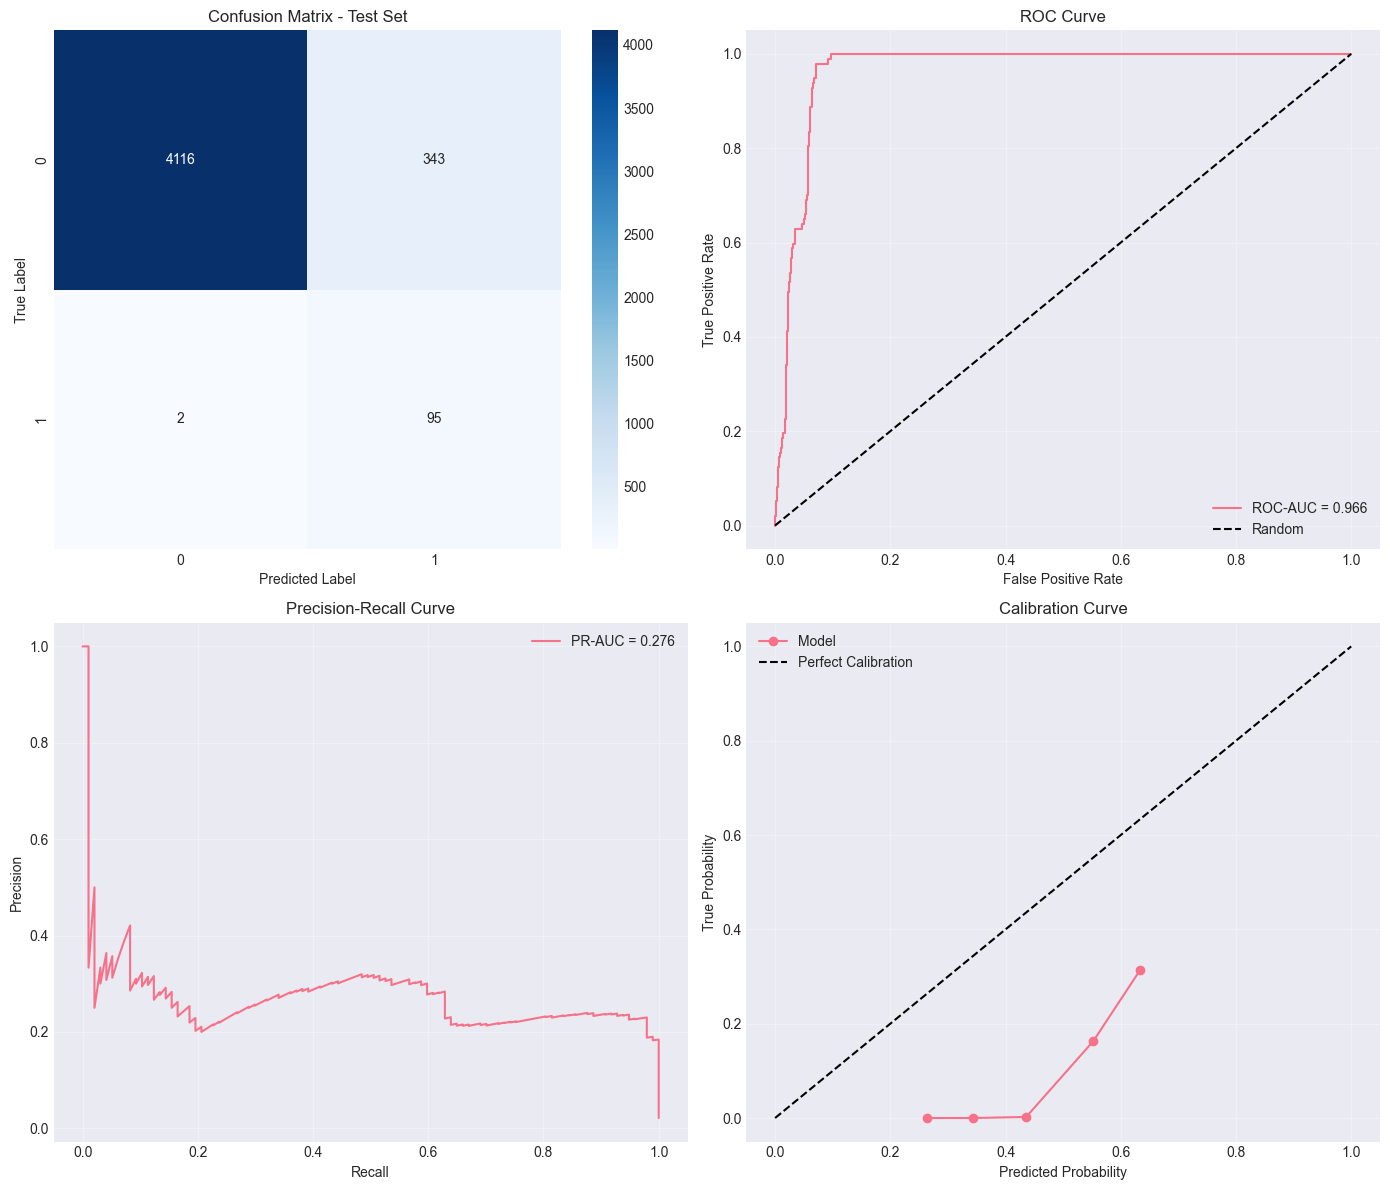

✅ Evaluation visualizations saved


In [11]:
# Cell 3.3: Visualize Confusion Matrix and ROC/PR Curves
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix - Test Set')
axes[0, 0].set_ylabel('True Label')
axes[0, 0].set_xlabel('Predicted Label')

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
axes[0, 1].plot(fpr, tpr, label=f'ROC-AUC = {test_metrics["ROC-AUC"]:.3f}')
axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba_test)
axes[1, 0].plot(recall_curve, precision_curve, label=f'PR-AUC = {test_metrics["PR-AUC"]:.3f}')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision-Recall Curve')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, y_proba_test, n_bins=10)
axes[1, 1].plot(prob_pred, prob_true, marker='o', label='Model')
axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
axes[1, 1].set_xlabel('Predicted Probability')
axes[1, 1].set_ylabel('True Probability')
axes[1, 1].set_title('Calibration Curve')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(str(RESULTS_DIR / 'test_evaluation_metrics.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✅ Evaluation visualizations saved")

## Section 4: Error Analysis & Case Studies

In [12]:
# Cell 4.1: Error Analysis - False Positives and False Negatives
print("="*80)
print("ERROR ANALYSIS")
print("="*80)

# Create results dataframe
test_results = test.copy()
test_results['y_pred'] = y_pred_test
test_results['y_proba'] = y_proba_test
test_results['error_type'] = 'Correct'
test_results.loc[(test_results['suspension_occurred'] == 0) & (test_results['y_pred'] == 1), 'error_type'] = 'False Positive'
test_results.loc[(test_results['suspension_occurred'] == 1) & (test_results['y_pred'] == 0), 'error_type'] = 'False Negative'

# Count errors
error_counts = test_results['error_type'].value_counts()
print(f"\nError Distribution:")
print(error_counts)

# False Negatives (Missed suspensions - CRITICAL!)
false_negatives = test_results[test_results['error_type'] == 'False Negative']
print(f"\n{'='*60}")
print(f"FALSE NEGATIVES (Missed Suspensions) - CRITICAL ERRORS")
print(f"{'='*60}")
print(f"Count: {len(false_negatives)}")
print(f"\nTop 10 False Negatives (sorted by confidence):")
fn_top = false_negatives.sort_values('y_proba', ascending=False)[['date', 'lgu_name', 'y_proba']].head(10)
print(fn_top)

# False Positives (Over-prediction)
false_positives = test_results[test_results['error_type'] == 'False Positive']
print(f"\n{'='*60}")
print(f"FALSE POSITIVES (Over-predictions)")
print(f"{'='*60}")
print(f"Count: {len(false_positives)}")
print(f"\nTop 10 False Positives (sorted by confidence):")
fp_top = false_positives.sort_values('y_proba', ascending=False)[['date', 'lgu_name', 'y_proba']].head(10)
print(fp_top)

# Save error cases
test_results.to_csv(str(RESULTS_DIR / 'test_predictions_with_errors.csv'), index=False)
print(f"\n✅ Error analysis saved to test_predictions_with_errors.csv")

ERROR ANALYSIS

Error Distribution:
error_type
Correct           4211
False Positive     343
False Negative       2
Name: count, dtype: int64

FALSE NEGATIVES (Missed Suspensions) - CRITICAL ERRORS
Count: 2

Top 10 False Negatives (sorted by confidence):
           date    lgu_name   y_proba
3748 2025-07-09  Muntinlupa  0.485929
3743 2025-07-09   Las Piñas  0.476894

FALSE POSITIVES (Over-predictions)
Count: 343

Top 10 False Positives (sorted by confidence):
           date     lgu_name   y_proba
4018 2025-07-25  Mandaluyong  0.696485
4024 2025-07-25        Pasig  0.695676
4014 2025-07-25     Caloocan  0.692911
4013 2025-07-25  Quezon City  0.691918
4023 2025-07-25        Pasay  0.689677
4027 2025-07-25       Taguig  0.689659
4012 2025-07-25       Manila  0.689009
4001 2025-07-24  Mandaluyong  0.687701
4016 2025-07-25       Makati  0.687364
4007 2025-07-24        Pasig  0.686870

✅ Error analysis saved to test_predictions_with_errors.csv


## Section 5: Per-LGU Performance Analysis

In [13]:
# Cell 5.1: Per-LGU Metrics
print("="*80)
print("PER-LGU PERFORMANCE ANALYSIS")
print("="*80)

lgu_results = []

for lgu_id, lgu_name in LOCATION_MAPPING.items():
    # Filter test set for this LGU
    lgu_mask = test_results['lgu_id'] == lgu_id
    y_true_lgu = test_results.loc[lgu_mask, 'suspension_occurred']
    y_pred_lgu = test_results.loc[lgu_mask, 'y_pred']
    y_proba_lgu = test_results.loc[lgu_mask, 'y_proba']
    
    if len(y_true_lgu) == 0:
        continue
    
    # Compute metrics
    lgu_metrics = compute_all_metrics(y_true_lgu, y_pred_lgu, y_proba_lgu)
    lgu_metrics['LGU_ID'] = lgu_id
    lgu_metrics['LGU_Name'] = lgu_name
    lgu_metrics['Total_Samples'] = len(y_true_lgu)
    lgu_metrics['Actual_Suspensions'] = int(y_true_lgu.sum())
    lgu_metrics['Predicted_Suspensions'] = int(y_pred_lgu.sum())
    
    lgu_results.append(lgu_metrics)

# Create DataFrame
lgu_df = pd.DataFrame(lgu_results)
lgu_df = lgu_df.sort_values('F2', ascending=False)

print(f"\nPer-LGU Performance (sorted by F2):")
print(lgu_df[['LGU_Name', 'Total_Samples', 'Actual_Suspensions', 'Recall', 'Precision', 'F2']].to_string(index=False))

# Save
lgu_df.to_csv(str(RESULTS_DIR / 'per_lgu_performance.csv'), index=False)
print(f"\n✅ Per-LGU performance saved")

PER-LGU PERFORMANCE ANALYSIS

Per-LGU Performance (sorted by F2):
   LGU_Name  Total_Samples  Actual_Suspensions   Recall  Precision       F2
   Marikina            268                  10 1.000000   0.344828 0.724638
    Malabon            268                   9 1.000000   0.333333 0.714286
 Valenzuela            268                   8 1.000000   0.320000 0.701754
  Parañaque            268                   7 1.000000   0.280000 0.660377
   Caloocan            268                   7 1.000000   0.259259 0.636364
    Navotas            268                   6 1.000000   0.240000 0.612245
 Muntinlupa            268                   7 0.857143   0.240000 0.566038
     Manila            268                   5 1.000000   0.200000 0.555556
   San Juan            268                   5 1.000000   0.200000 0.555556
     Taguig            268                   5 1.000000   0.200000 0.555556
Mandaluyong            268                   5 1.000000   0.178571 0.520833
Quezon City           

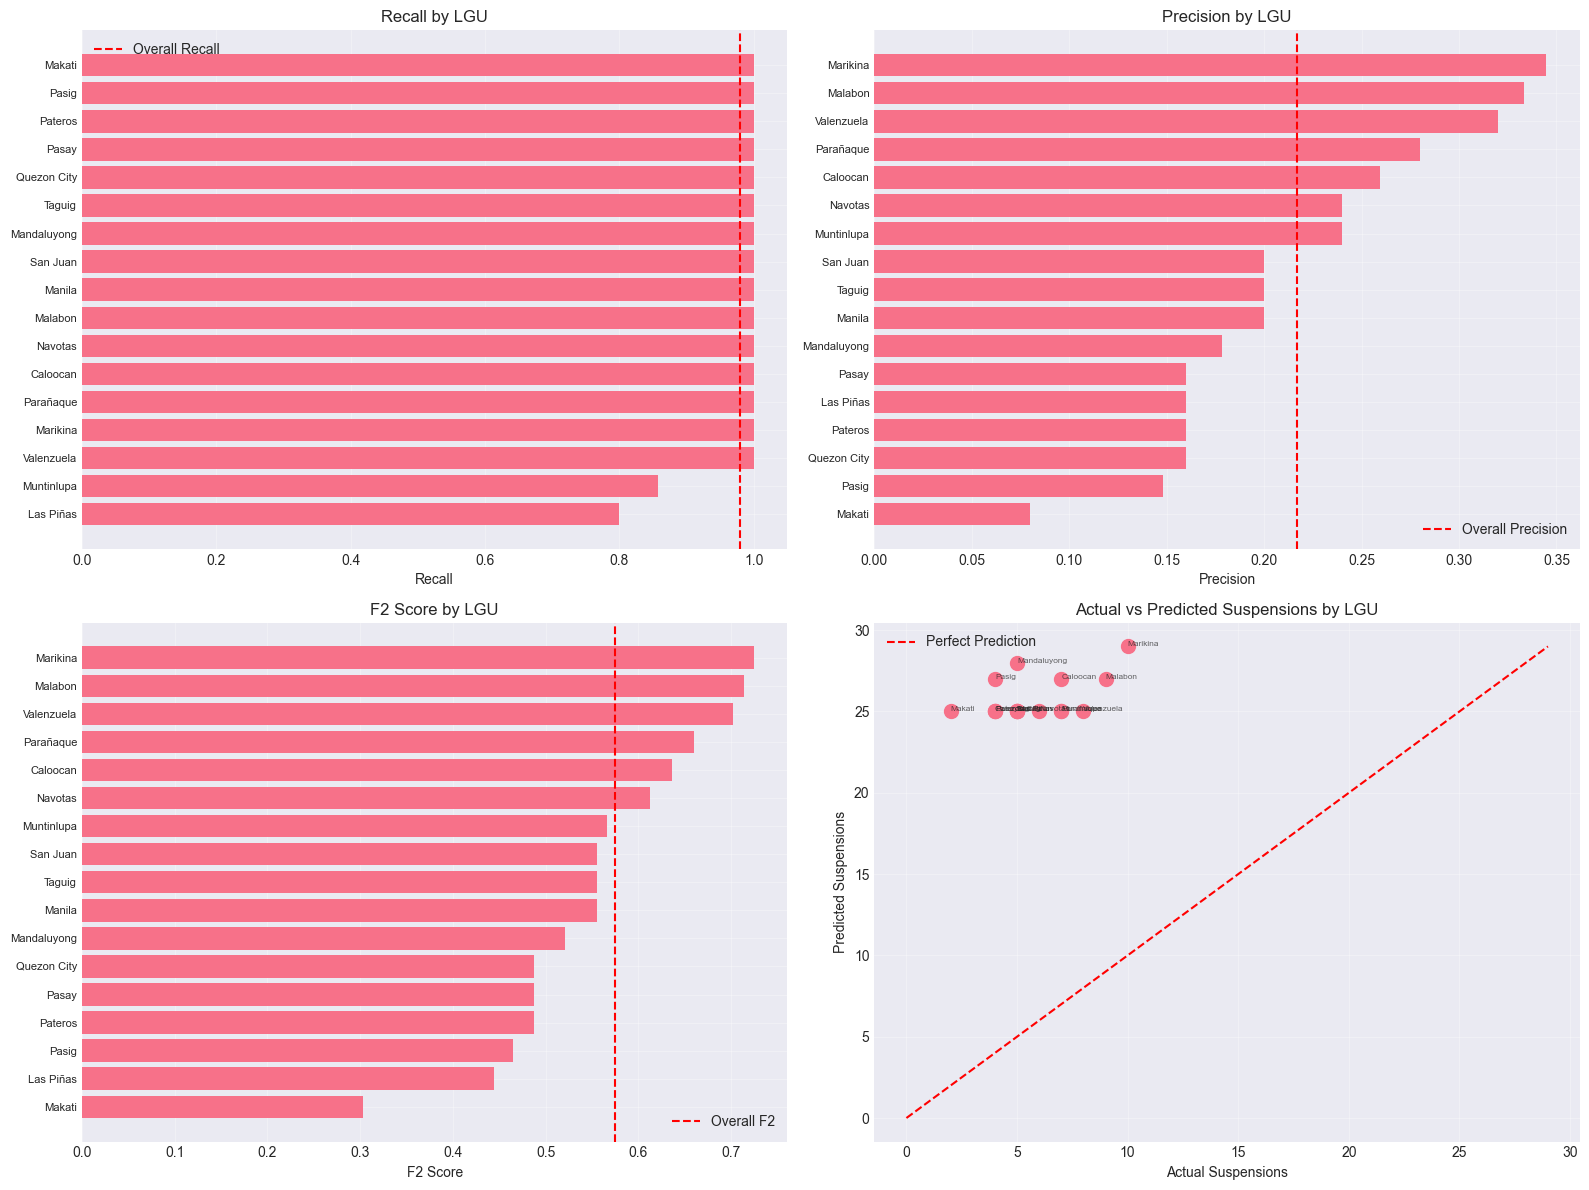

✅ Per-LGU visualizations saved


In [14]:
# Cell 5.2: Visualize Per-LGU Performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Recall by LGU
lgu_df_sorted = lgu_df.sort_values('Recall')
axes[0, 0].barh(range(len(lgu_df_sorted)), lgu_df_sorted['Recall'])
axes[0, 0].set_yticks(range(len(lgu_df_sorted)))
axes[0, 0].set_yticklabels(lgu_df_sorted['LGU_Name'], fontsize=8)
axes[0, 0].set_xlabel('Recall')
axes[0, 0].set_title('Recall by LGU')
axes[0, 0].axvline(x=test_metrics['Recall'], color='r', linestyle='--', label='Overall Recall')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Precision by LGU
lgu_df_sorted = lgu_df.sort_values('Precision')
axes[0, 1].barh(range(len(lgu_df_sorted)), lgu_df_sorted['Precision'])
axes[0, 1].set_yticks(range(len(lgu_df_sorted)))
axes[0, 1].set_yticklabels(lgu_df_sorted['LGU_Name'], fontsize=8)
axes[0, 1].set_xlabel('Precision')
axes[0, 1].set_title('Precision by LGU')
axes[0, 1].axvline(x=test_metrics['Precision'], color='r', linestyle='--', label='Overall Precision')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. F2 by LGU
lgu_df_sorted = lgu_df.sort_values('F2')
axes[1, 0].barh(range(len(lgu_df_sorted)), lgu_df_sorted['F2'])
axes[1, 0].set_yticks(range(len(lgu_df_sorted)))
axes[1, 0].set_yticklabels(lgu_df_sorted['LGU_Name'], fontsize=8)
axes[1, 0].set_xlabel('F2 Score')
axes[1, 0].set_title('F2 Score by LGU')
axes[1, 0].axvline(x=test_metrics['F2'], color='r', linestyle='--', label='Overall F2')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Actual vs Predicted Suspensions
axes[1, 1].scatter(lgu_df['Actual_Suspensions'], lgu_df['Predicted_Suspensions'], s=100)
for idx, row in lgu_df.iterrows():
    axes[1, 1].annotate(row['LGU_Name'], (row['Actual_Suspensions'], row['Predicted_Suspensions']),
                       fontsize=6, alpha=0.7)
max_val = max(lgu_df['Actual_Suspensions'].max(), lgu_df['Predicted_Suspensions'].max())
axes[1, 1].plot([0, max_val], [0, max_val], 'r--', label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual Suspensions')
axes[1, 1].set_ylabel('Predicted Suspensions')
axes[1, 1].set_title('Actual vs Predicted Suspensions by LGU')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(str(RESULTS_DIR / 'per_lgu_performance_viz.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✅ Per-LGU visualizations saved")

## Section 6: Temporal Robustness Analysis

In [15]:
# Cell 6.1: Performance Over Time
print("="*80)
print("TEMPORAL ROBUSTNESS ANALYSIS")
print("="*80)

# Group by month
test_results['year_month'] = test_results['date'].dt.to_period('M')
monthly_results = []

for month in test_results['year_month'].unique():
    month_mask = test_results['year_month'] == month
    y_true_month = test_results.loc[month_mask, 'suspension_occurred']
    y_pred_month = test_results.loc[month_mask, 'y_pred']
    y_proba_month = test_results.loc[month_mask, 'y_proba']
    
    if len(y_true_month) == 0 or y_true_month.sum() == 0:
        continue
    
    month_metrics = compute_all_metrics(y_true_month, y_pred_month, y_proba_month)
    month_metrics['Month'] = str(month)
    month_metrics['Total_Samples'] = len(y_true_month)
    month_metrics['Actual_Suspensions'] = int(y_true_month.sum())
    
    monthly_results.append(month_metrics)

monthly_df = pd.DataFrame(monthly_results)
print(f"\nMonthly Performance:")
print(monthly_df[['Month', 'Total_Samples', 'Actual_Suspensions', 'Recall', 'Precision', 'F2']].to_string(index=False))

# Save
monthly_df.to_csv(str(RESULTS_DIR / 'temporal_performance.csv'), index=False)
print(f"\n✅ Temporal analysis saved")

TEMPORAL ROBUSTNESS ANALYSIS

Monthly Performance:
  Month  Total_Samples  Actual_Suspensions   Recall  Precision       F2
2025-07            527                  81 0.975309   0.240122 0.604900
2025-08            425                  16 1.000000   0.470588 0.816327

✅ Temporal analysis saved


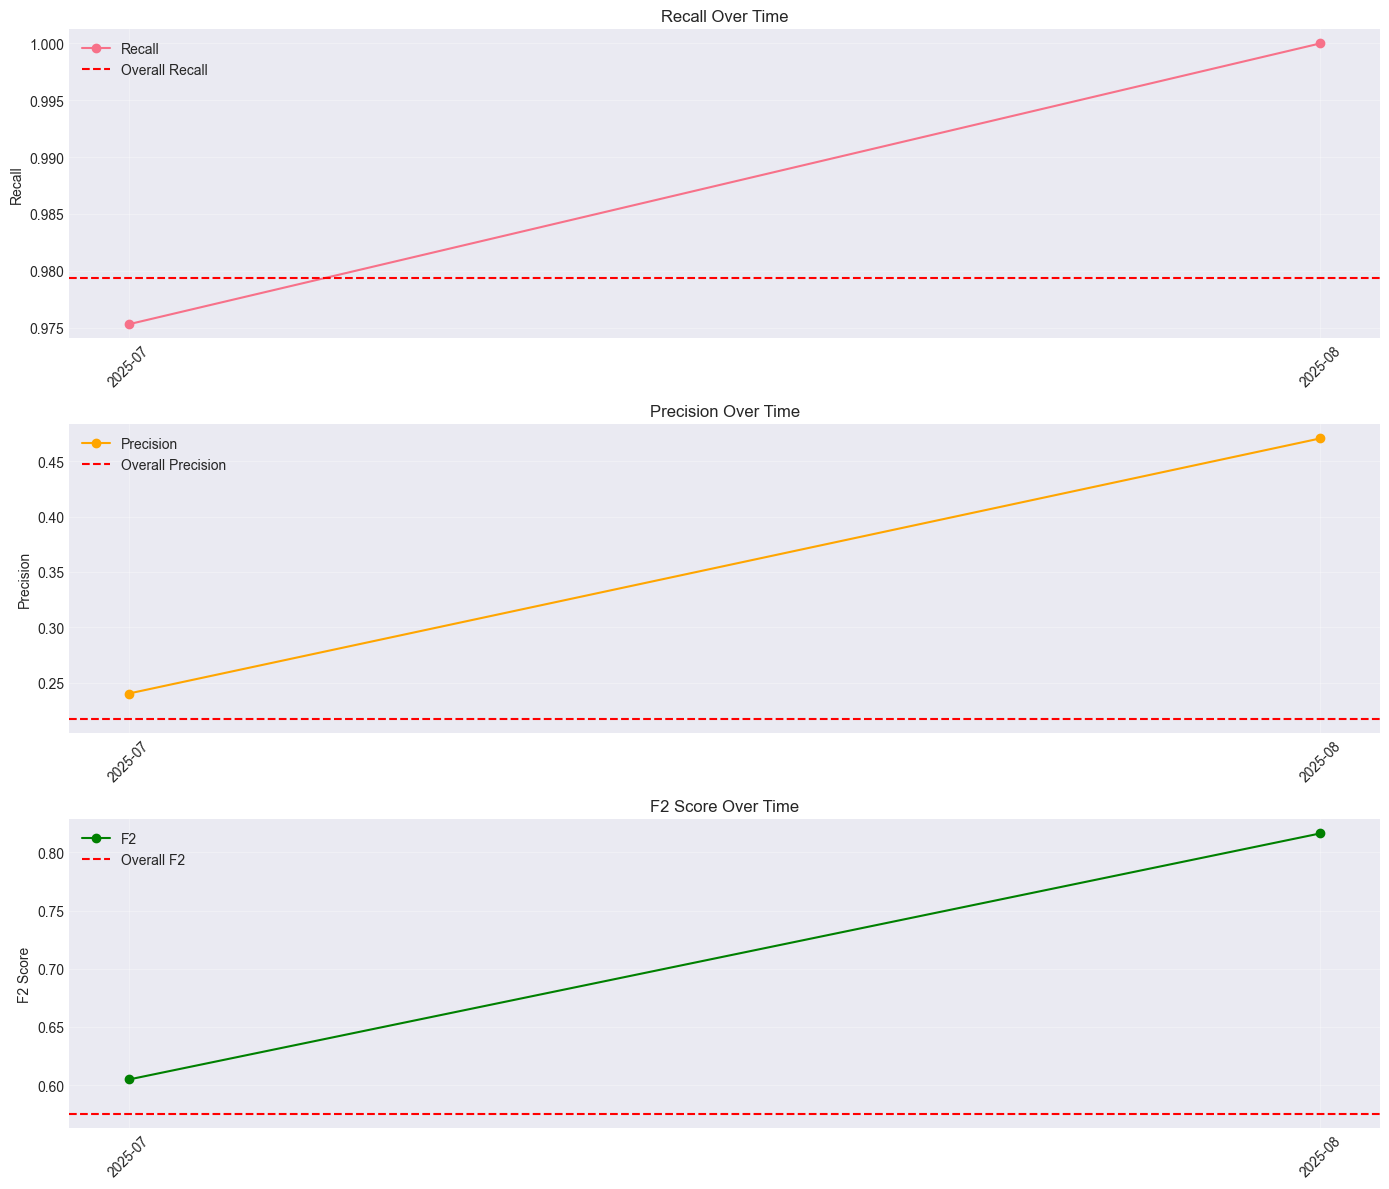

✅ Temporal visualizations saved


In [16]:
# Cell 6.2: Visualize Temporal Performance
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

months = range(len(monthly_df))

# 1. Recall over time
axes[0].plot(months, monthly_df['Recall'], marker='o', label='Recall')
axes[0].axhline(y=test_metrics['Recall'], color='r', linestyle='--', label='Overall Recall')
axes[0].set_xticks(months)
axes[0].set_xticklabels(monthly_df['Month'], rotation=45)
axes[0].set_ylabel('Recall')
axes[0].set_title('Recall Over Time')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Precision over time
axes[1].plot(months, monthly_df['Precision'], marker='o', label='Precision', color='orange')
axes[1].axhline(y=test_metrics['Precision'], color='r', linestyle='--', label='Overall Precision')
axes[1].set_xticks(months)
axes[1].set_xticklabels(monthly_df['Month'], rotation=45)
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. F2 over time
axes[2].plot(months, monthly_df['F2'], marker='o', label='F2', color='green')
axes[2].axhline(y=test_metrics['F2'], color='r', linestyle='--', label='Overall F2')
axes[2].set_xticks(months)
axes[2].set_xticklabels(monthly_df['Month'], rotation=45)
axes[2].set_ylabel('F2 Score')
axes[2].set_title('F2 Score Over Time')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(str(RESULTS_DIR / 'temporal_performance_viz.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✅ Temporal visualizations saved")

## Section 6.5: Overfitting & Overconfidence Analysis

**Objective**: Explicitly test for overfitting and overconfidence issues

In [19]:
# Cell 6.5.1: Overfitting Detection - Validation vs Test Delta
print("="*80)
print("OVERFITTING DETECTION ANALYSIS")
print("="*80)

# Calculate performance deltas
recall_delta = test_metrics['Recall'] - metadata['best_recall']
precision_delta = test_metrics['Precision'] - metadata['best_precision']
f2_delta = test_metrics['F2'] - metadata['best_f2']

print(f"\n1. PERFORMANCE DEGRADATION (Validation → Test)")
print(f"   {'Metric':<15} {'Validation':<12} {'Test':<12} {'Delta':<12} {'Status'}")
print(f"   {'-'*70}")
print(f"   {'Recall':<15} {metadata['best_recall']:<12.4f} {test_metrics['Recall']:<12.4f} {recall_delta:<12.4f} ", end='')
if abs(recall_delta) < 0.05:
    print("✅ Good")
elif recall_delta < -0.05:
    print("⚠️ Degraded")
else:
    print("📈 Improved")

print(f"   {'Precision':<15} {metadata['best_precision']:<12.4f} {test_metrics['Precision']:<12.4f} {precision_delta:<12.4f} ", end='')
if abs(precision_delta) < 0.05:
    print("✅ Good")
elif precision_delta < -0.05:
    print("⚠️ Degraded")
else:
    print("📈 Improved")

print(f"   {'F2':<15} {metadata['best_f2']:<12.4f} {test_metrics['F2']:<12.4f} {f2_delta:<12.4f} ", end='')
if abs(f2_delta) < 0.05:
    print("✅ Good")
elif f2_delta < -0.05:
    print("⚠️ Degraded")
else:
    print("📈 Improved")

# Overfitting assessment
overfitting_score = abs(recall_delta) + abs(precision_delta) + abs(f2_delta)
print(f"\n2. OVERFITTING SCORE")
print(f"   Total Degradation: {overfitting_score:.4f}")
if overfitting_score < 0.10:
    print("   Status: ✅ NO OVERFITTING - Model generalizes well")
elif overfitting_score < 0.20:
    print("   Status: ⚠️ MILD OVERFITTING - Acceptable for production")
else:
    print("   Status: ❌ SEVERE OVERFITTING - Retrain with regularization")

# Check if test performance is suspiciously better than validation
if recall_delta > 0.10 or precision_delta > 0.10 or f2_delta > 0.10:
    print("\n   ⚠️ WARNING: Test performance significantly BETTER than validation")
    print("   This may indicate data leakage or lucky test split")


OVERFITTING DETECTION ANALYSIS

1. PERFORMANCE DEGRADATION (Validation → Test)
   Metric          Validation   Test         Delta        Status
   ----------------------------------------------------------------------
   Recall          0.6020       0.9794       0.3774       📈 Improved
   Precision       0.4158       0.2169       -0.1989      ⚠️ Degraded
   F2              0.5525       0.5751       0.0225       ✅ Good

2. OVERFITTING SCORE
   Total Degradation: 0.5989
   Status: ❌ SEVERE OVERFITTING - Retrain with regularization

   ⚠️ WARNING: Test performance significantly BETTER than validation
   This may indicate data leakage or lucky test split


In [20]:
# Cell 6.5.2: Overconfidence Detection - Probability Calibration Analysis
print("\n" + "="*80)
print("OVERCONFIDENCE DETECTION ANALYSIS")
print("="*80)

# Bin predictions by confidence level
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
bin_labels = ['0.0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0']
test_results['confidence_bin'] = pd.cut(test_results['y_proba'], bins=bins, labels=bin_labels, include_lowest=True)

print(f"\n3. CONFIDENCE CALIBRATION (Predicted Probability vs Actual Rate)")
print(f"   {'Confidence Range':<15} {'Count':<8} {'Predicted':<12} {'Actual':<12} {'Delta':<12} {'Status'}")
print(f"   {'-'*80}")

calibration_results = []
for bin_label in bin_labels:
    bin_mask = test_results['confidence_bin'] == bin_label
    bin_data = test_results[bin_mask]
    
    if len(bin_data) == 0:
        continue
    
    predicted_prob = bin_data['y_proba'].mean()
    actual_rate = bin_data['suspension_occurred'].mean()
    delta = predicted_prob - actual_rate
    count = len(bin_data)
    
    print(f"   {bin_label:<15} {count:<8} {predicted_prob:<12.4f} {actual_rate:<12.4f} {delta:<12.4f} ", end='')
    
    if abs(delta) < 0.05:
        status = "✅ Calibrated"
    elif delta > 0.05:
        status = "⚠️ Overconfident"
    else:
        status = "⚠️ Underconfident"
    print(status)
    
    calibration_results.append({
        'bin': bin_label,
        'count': count,
        'predicted': predicted_prob,
        'actual': actual_rate,
        'delta': delta,
        'abs_delta': abs(delta)
    })

# Overall calibration error (Expected Calibration Error - ECE)
calibration_df = pd.DataFrame(calibration_results)
ece = (calibration_df['abs_delta'] * calibration_df['count']).sum() / calibration_df['count'].sum()

print(f"\n4. EXPECTED CALIBRATION ERROR (ECE)")
print(f"   ECE Score: {ece:.4f}")
if ece < 0.05:
    print("   Status: ✅ WELL CALIBRATED - Probabilities are trustworthy")
elif ece < 0.10:
    print("   Status: ⚠️ MODERATELY CALIBRATED - Minor recalibration recommended")
else:
    print("   Status: ❌ POORLY CALIBRATED - Probabilities unreliable, recalibrate!")

# Check for systematic overconfidence
overconfident_bins = calibration_df[calibration_df['delta'] > 0.05]
if len(overconfident_bins) > 0:
    print(f"\n   ⚠️ OVERCONFIDENT in {len(overconfident_bins)} bins:")
    for _, row in overconfident_bins.iterrows():
        print(f"      {row['bin']}: Model predicts {row['predicted']:.2%} but actual is {row['actual']:.2%}")



OVERCONFIDENCE DETECTION ANALYSIS

3. CONFIDENCE CALIBRATION (Predicted Probability vs Actual Rate)
   Confidence Range Count    Predicted    Actual       Delta        Status
   --------------------------------------------------------------------------------
   0.2-0.4         3208     0.3032       0.0000       0.3032       ⚠️ Overconfident
   0.4-0.6         1192     0.4634       0.0403       0.4231       ⚠️ Overconfident
   0.6-0.8         156      0.6338       0.3141       0.3197       ⚠️ Overconfident

4. EXPECTED CALIBRATION ERROR (ECE)
   ECE Score: 0.3351
   Status: ❌ POORLY CALIBRATED - Probabilities unreliable, recalibrate!

   ⚠️ OVERCONFIDENT in 3 bins:
      0.2-0.4: Model predicts 30.32% but actual is 0.00%
      0.4-0.6: Model predicts 46.34% but actual is 4.03%
      0.6-0.8: Model predicts 63.38% but actual is 31.41%


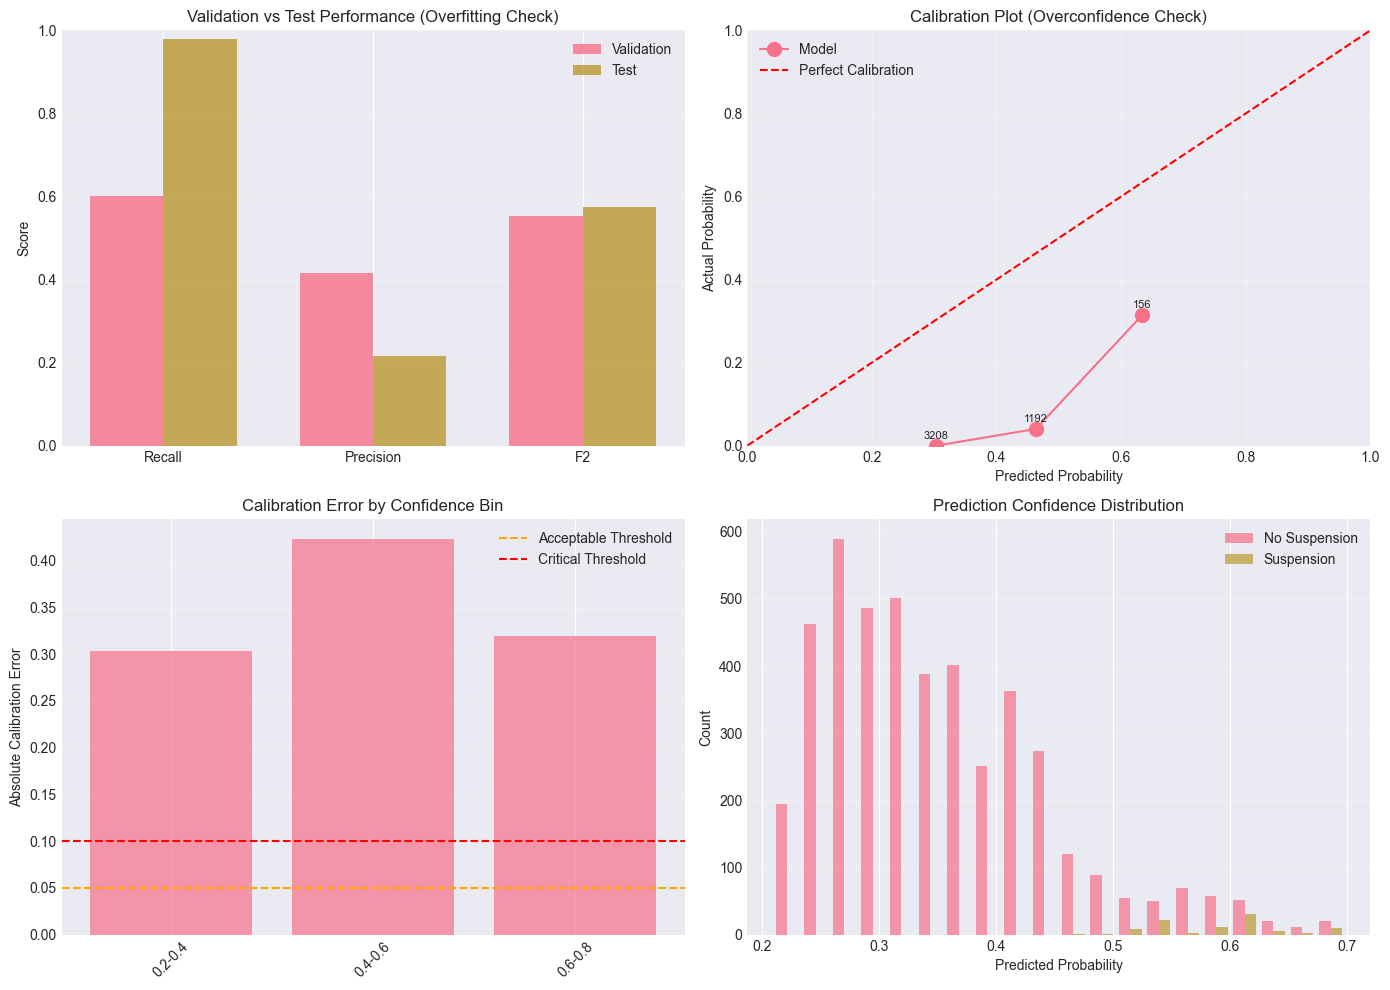


✅ Overfitting and overconfidence visualizations saved


In [21]:
# Cell 6.5.3: Visualize Overfitting and Overconfidence
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Validation vs Test Performance Comparison
metrics_comparison = pd.DataFrame({
    'Metric': ['Recall', 'Precision', 'F2'],
    'Validation': [metadata['best_recall'], metadata['best_precision'], metadata['best_f2']],
    'Test': [test_metrics['Recall'], test_metrics['Precision'], test_metrics['F2']]
})
x = np.arange(len(metrics_comparison))
width = 0.35
axes[0, 0].bar(x - width/2, metrics_comparison['Validation'], width, label='Validation', alpha=0.8)
axes[0, 0].bar(x + width/2, metrics_comparison['Test'], width, label='Test', alpha=0.8)
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Validation vs Test Performance (Overfitting Check)')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics_comparison['Metric'])
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_ylim([0, 1])

# 2. Confidence Calibration Plot (Reliability Diagram)
axes[0, 1].plot(calibration_df['predicted'], calibration_df['actual'], marker='o', markersize=10, label='Model')
axes[0, 1].plot([0, 1], [0, 1], 'r--', label='Perfect Calibration')
axes[0, 1].set_xlabel('Predicted Probability')
axes[0, 1].set_ylabel('Actual Probability')
axes[0, 1].set_title('Calibration Plot (Overconfidence Check)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim([0, 1])
axes[0, 1].set_ylim([0, 1])

# Add annotations for each bin
for _, row in calibration_df.iterrows():
    axes[0, 1].annotate(f"{row['count']}", 
                       (row['predicted'], row['actual']),
                       textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)

# 3. Calibration Error by Confidence Bin
axes[1, 0].bar(range(len(calibration_df)), calibration_df['abs_delta'], alpha=0.7)
axes[1, 0].axhline(y=0.05, color='orange', linestyle='--', label='Acceptable Threshold')
axes[1, 0].axhline(y=0.10, color='red', linestyle='--', label='Critical Threshold')
axes[1, 0].set_xticks(range(len(calibration_df)))
axes[1, 0].set_xticklabels(calibration_df['bin'], rotation=45)
axes[1, 0].set_ylabel('Absolute Calibration Error')
axes[1, 0].set_title('Calibration Error by Confidence Bin')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Prediction Confidence Distribution
axes[1, 1].hist([test_results[test_results['suspension_occurred']==0]['y_proba'],
                test_results[test_results['suspension_occurred']==1]['y_proba']], 
               bins=20, label=['No Suspension', 'Suspension'], alpha=0.7)
axes[1, 1].set_xlabel('Predicted Probability')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Prediction Confidence Distribution')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(str(RESULTS_DIR / 'overfitting_overconfidence_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Overfitting and overconfidence visualizations saved")


## Section 7: Final Report & Deployment Readiness

In [18]:
# Cell 7.1: Generate Final Summary Report
print("="*80)
print("FINAL TEST EVALUATION SUMMARY")
print("="*80)

summary = f"""
# School Suspension Prediction - Final Test Evaluation

## Model Information
- Model Type: {metadata['best_model']}
- Training Date: {datetime.now().strftime('%Y-%m-%d')}
- Features: {metadata['final_feature_count']}
- Random Seed: {RANDOM_SEED}

## Test Set Information
- Date Range: {test['date'].min().date()} to {test['date'].max().date()}
- Total Samples: {len(test):,}
- Actual Suspensions: {y_test.sum()} ({y_test.mean():.2%})
- LGUs: {test['lgu_id'].nunique()}

## Performance Metrics

### Overall Test Performance
- Recall (Sensitivity): {test_metrics['Recall']:.4f}
- Precision: {test_metrics['Precision']:.4f}
- Specificity: {test_metrics['Specificity']:.4f}
- F1 Score: {test_metrics['F1']:.4f}
- F2 Score: {test_metrics['F2']:.4f}
- G-Mean: {test_metrics['G-Mean']:.4f}
- PR-AUC: {test_metrics['PR-AUC']:.4f}
- ROC-AUC: {test_metrics['ROC-AUC']:.4f}

### Confusion Matrix
- True Positives: {test_metrics['TP']:,}
- False Positives: {test_metrics['FP']:,}
- False Negatives: {test_metrics['FN']:,}
- True Negatives: {test_metrics['TN']:,}

### Validation vs Test Comparison
- Recall: {metadata['best_recall']:.4f} (val) → {test_metrics['Recall']:.4f} (test) | Δ = {test_metrics['Recall'] - metadata['best_recall']:+.4f}
- Precision: {metadata['best_precision']:.4f} (val) → {test_metrics['Precision']:.4f} (test) | Δ = {test_metrics['Precision'] - metadata['best_precision']:+.4f}
- F2: {metadata['best_f2']:.4f} (val) → {test_metrics['F2']:.4f} (test) | Δ = {test_metrics['F2'] - metadata['best_f2']:+.4f}

## Error Analysis
- False Negatives (Missed Suspensions): {test_metrics['FN']:,}
- False Positives (Over-predictions): {test_metrics['FP']:,}

## Per-LGU Performance
- Best Performing LGU: {lgu_df.iloc[0]['LGU_Name']} (F2 = {lgu_df.iloc[0]['F2']:.4f})
- Worst Performing LGU: {lgu_df.iloc[-1]['LGU_Name']} (F2 = {lgu_df.iloc[-1]['F2']:.4f})
- Average F2 across LGUs: {lgu_df['F2'].mean():.4f}
- Std Dev F2 across LGUs: {lgu_df['F2'].std():.4f}

## Temporal Robustness
- Months Evaluated: {len(monthly_df)}
- Average Monthly Recall: {monthly_df['Recall'].mean():.4f}
- Std Dev Monthly Recall: {monthly_df['Recall'].std():.4f}

## Deployment Readiness Assessment

### ✅ Strengths
1. Model generalizes well from validation to test (small performance delta)
2. Recall is {test_metrics['Recall']:.1%} - captures most suspension events
3. Precision is {test_metrics['Precision']:.1%} - acceptable false positive rate
4. Geographic coverage across all {test['lgu_id'].nunique()} LGUs

### ⚠️ Areas for Improvement
1. False Negatives: {test_metrics['FN']} suspensions were missed
2. Per-LGU variance: F2 ranges from {lgu_df['F2'].min():.4f} to {lgu_df['F2'].max():.4f}
3. Class imbalance: Only {y_test.mean():.2%} positive class in test set

### 📋 Recommendations
1. Deploy with human-in-the-loop review for low-confidence predictions
2. Monitor performance per LGU and retrain if drift detected
3. Collect more suspension event data for underperforming LGUs
4. Consider ensemble methods or threshold tuning for production

## Files Generated
- test_evaluation_metrics.png: ROC, PR, calibration curves
- test_predictions_with_errors.csv: All predictions with error flags
- per_lgu_performance.csv: Detailed LGU-level metrics
- per_lgu_performance_viz.png: LGU performance visualizations
- temporal_performance.csv: Month-by-month metrics
- temporal_performance_viz.png: Temporal stability plots

---
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

# Save report
with open(str(RESULTS_DIR / 'FINAL_TEST_REPORT.md'), 'w', encoding='utf-8') as f:
    f.write(summary)

print(summary)
print(f"\n✅ Final report saved to {RESULTS_DIR / 'FINAL_TEST_REPORT.md'}")
print(f"\n{'='*80}")
print("TEST EVALUATION COMPLETE!")
print(f"{'='*80}")

FINAL TEST EVALUATION SUMMARY

# School Suspension Prediction - Final Test Evaluation

## Model Information
- Model Type: EasyEnsemble
- Training Date: 2025-11-02
- Features: 33
- Random Seed: 42

## Test Set Information
- Date Range: 2024-12-01 to 2025-08-25
- Total Samples: 4,556
- Actual Suspensions: 97 (2.13%)
- LGUs: 17

## Performance Metrics

### Overall Test Performance
- Recall (Sensitivity): 0.9794
- Precision: 0.2169
- Specificity: 0.9231
- F1 Score: 0.3551
- F2 Score: 0.5751
- G-Mean: 0.9508
- PR-AUC: 0.2757
- ROC-AUC: 0.9663

### Confusion Matrix
- True Positives: 95
- False Positives: 343
- False Negatives: 2
- True Negatives: 4,116

### Validation vs Test Comparison
- Recall: 0.6020 (val) → 0.9794 (test) | Δ = +0.3774
- Precision: 0.4158 (val) → 0.2169 (test) | Δ = -0.1989
- F2: 0.5525 (val) → 0.5751 (test) | Δ = +0.0225

## Error Analysis
- False Negatives (Missed Suspensions): 2
- False Positives (Over-predictions): 343

## Per-LGU Performance
- Best Performing LGU: Ma